<a href="https://colab.research.google.com/github/krmonline/Sentiment-Analysis-in-Social-Networks/blob/master/w2vClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pythainlp
!pip install emoji
!pip install deepcut

In [2]:
import pythainlp.word_vector
import pandas as pd
import numpy as np

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
pythainlp.word_vector.similarity("คน", "มนุษย์")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.2504981

In [4]:
model = pythainlp.word_vector.get_model()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [5]:
thai2dict = {}
for word in model.index2word:
    thai2dict[word] = model[word]
thai2vec = pd.DataFrame.from_dict(thai2dict,orient='index')
thai2vec.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
ที่,0.308956,-0.097699,0.116745,0.215612,0.015768,-0.064163,0.062168,0.039649,0.864940,0.846904,-0.080623,-0.231181,-0.092922,0.295904,-0.043141,-0.095836,0.088743,0.077047,-0.059335,0.022008,-0.045684,0.251084,-0.004513,0.213463,-0.044485,-0.441761,-0.063019,-0.412640,0.116379,-0.387046,0.034444,-0.043999,0.011384,-0.140900,-0.395825,0.237268,0.270278,0.216423,-0.034941,1.378542,...,0.086272,0.410396,-0.001171,0.009646,0.169346,0.172114,0.155705,-0.005084,-0.189634,0.138100,0.197152,-0.593183,-0.050520,-0.232437,0.316324,-0.298040,0.035917,-0.509016,0.221730,-0.211563,-0.007943,-0.158455,0.073451,0.260001,0.074339,0.013533,0.068816,0.402744,0.014355,-0.351401,-0.142418,0.033241,0.171581,-0.624864,-0.009358,0.449131,0.120130,-0.122195,-0.450617,-0.071318
และ,0.010751,-0.618971,0.129665,0.035460,-0.007560,0.027607,0.397824,0.026543,0.254075,0.168328,-0.098588,0.257041,-0.056433,0.004745,-0.194496,-0.094631,-0.223221,0.137139,-0.072942,0.002684,-0.078874,0.010818,-0.371821,0.222702,-0.131057,-0.178166,0.007801,-0.393077,0.529949,-0.310193,0.013337,-0.018138,-0.300043,-0.050325,-0.551239,0.283270,-0.243382,0.377265,0.139683,0.590561,...,0.018532,-0.471577,0.079897,-0.019969,0.066242,0.034164,0.059199,-0.130565,-0.201851,0.071434,-0.553549,-0.957159,-0.120453,-0.170949,0.513533,-0.167251,0.030702,-0.031545,0.589607,-0.029119,-0.081944,-0.133871,-0.175475,0.175725,0.032841,-0.080204,-0.087022,0.375683,0.090828,-0.180471,-0.105786,0.180930,-0.101630,0.070885,-0.037263,0.183606,-0.049088,-0.672288,-1.293044,0.592576
เป็น,-0.015736,-0.258926,0.052953,0.153728,-0.005985,-0.021081,0.041088,0.057312,1.633230,0.442729,-0.119677,-0.250198,-0.163293,0.259298,0.314523,-0.171628,0.000620,0.149310,0.045131,0.002716,0.033260,0.021520,-0.245065,0.229370,-0.125458,-0.228873,0.012631,0.338290,0.127649,-0.358579,0.020668,-0.405923,-0.023469,-0.127814,0.082412,0.051234,-0.303059,0.158995,-0.093958,0.103708,...,-0.081273,0.817347,-0.079280,-0.044231,0.064045,0.191203,0.109252,0.096903,-0.224083,0.174756,0.877677,-0.680886,-0.014604,-0.247449,-0.561851,-0.516297,0.095236,-0.796393,-0.389905,-0.138541,0.023499,0.167832,0.016259,0.168277,0.063619,-0.019294,-0.102617,0.296282,0.423037,-0.279272,-0.009408,-0.252576,-0.305512,0.372542,0.049151,0.568470,0.266586,0.400800,-0.784650,0.197369
ของ,-0.189711,-0.174774,0.171124,-0.186771,0.054294,-0.114150,-1.109456,-0.094466,-0.447015,0.042377,-0.064146,-0.149785,-0.093186,-0.354552,0.237786,-0.078743,-0.107498,0.129285,-0.053666,-0.019932,-0.059581,0.293966,-0.231959,0.040548,-0.113000,-0.299660,-0.066242,-0.208456,-0.022088,-0.340317,0.085374,-0.036507,-2.652814,-0.037416,-0.429546,0.330746,-0.494577,0.118136,0.219643,0.443018,...,0.081878,0.603002,0.074993,0.020903,0.132566,0.015298,0.062580,-0.213313,-0.155607,0.089085,-0.410915,-0.908669,-0.051955,-0.219557,0.248354,-0.214270,0.068104,-0.181821,-0.020594,-0.116557,-0.150756,-0.271633,-0.262408,0.253101,0.098220,-0.000184,0.096545,0.444684,-0.306692,-0.320713,-0.168676,-0.148738,0.680404,0.097702,0.020270,0.182967,-0.083949,0.006287,-0.707434,-0.070234
มี,-0.156962,-0.231863,0.080312,0.323157,0.215695,0.055145,0.420794,0.016842,0.256759,0.832864,-0.019295,-0.216187,-0.084874,0.490498,-0.056507,-0.127134,-0.142764,0.056968,-0.049709,0.016941,0.052464,0.290505,0.137538,0.533145,-0.000178,-0.248639,-0.038150,-0.213958,-0.000181,-0.272026,0.036652,0.001714,0.095409,-0.112760,-0.386491,-0.063893,-0.213437,0.597442,0.022917,0.260411,...,-0.070774,0.311335,0.066876,-0.063675,0.028047,0.141558,0.106993,-0.113822,-0.293616,0.181610,0.515976,-0.932181,-0.003411,-0.186245,-0.664680,-0.025371,0.222201,-0.795720,0.366739,0.150896,0.263638,-0.137672,-0.390320,0.123317,0.089979,0.119934,-0.029731,0.2240

In [6]:
all_df = pd.read_csv("https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/train.txt",names=['texts'])
all_df['lab'] = pd.read_csv("https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/train_label.txt",names=['lab'])
test_df = pd.read_csv("https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/test.txt",names=['texts'])
test_df['real'] = pd.read_csv("https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/test_label.txt",names=['real'])

In [7]:
all_df["processed"] = all_df.texts.map(lambda x: "|".join(pythainlp.tokenize.word_tokenize(x,engine='newmm')))
test_df["processed"] = test_df.texts.map(lambda x: "|".join(pythainlp.tokenize.word_tokenize(x,engine='newmm')))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_df.processed.iloc[:], all_df.lab[:], test_size=0.2, random_state=42)

In [9]:
X_train.shape,X_test.shape

((19250,), (4813,))

In [10]:
id2w = thai2vec.index.values
#Handle UNK
id2w = np.append(id2w,"UNK")
w2id = {}
for i in range(len(id2w)):
  w2id[id2w[i]] = i
print(len(id2w))

51359


In [11]:
tmp2 = []
j = 0
for i in X_train.values:
  j = j +1
  if j % 200  == 0:
    print("")
  else:
    print(j,end=" ")
  tmp = []
  for x in i.split("|"):
    if x in id2w:
      tmp.append(w2id[x])
    else:
      #UNK
      tmp.append(w2id['UNK'])
  tmp2.append(tmp)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278

In [12]:
max_length = max([len(i) for i in tmp2])
max_length

663

In [13]:
from keras.preprocessing import sequence

Using TensorFlow backend.


In [14]:
tmp3 = []
j = 0
for i in X_test.values:
  j = j +1
  if j % 200  == 0:
    print("")
  else:
    print(j,end=" ")
  tmp = []
  for x in i.split("|"):
    if x in id2w:
      tmp.append(w2id[x])
    else:
      #UNK
      tmp.append(w2id['UNK'])
  tmp3.append(tmp)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278

In [15]:
m = max([len(i) for i in tmp2])
max_length  = m if m > max_length else max_length
print(max_length)

663


In [16]:
X_train = sequence.pad_sequences(tmp2, maxlen=max_length,truncating='post')
X_test = sequence.pad_sequences(tmp3, maxlen=max_length,truncating='post')
print(X_train.shape,X_test.shape)

(19250, 663) (4813, 663)


In [17]:
y_train = pd.get_dummies(y_train, prefix='y')
y_test = pd.get_dummies(y_test, prefix='y')

In [18]:
import collections
import numpy as np
import numpy.random
import keras.preprocessing
import pandas as pd
import pickle
import glob
import deepcut
import re
import random
from pathlib import Path
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking,Flatten,Conv1D,GlobalMaxPooling1D
#from keras_contrib.layers import CRF
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as K
from pythainlp.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [19]:
embedding_matrix = thai2vec.values
print(embedding_matrix.shape)
#Append UNK
embedding_matrix = np.concatenate([embedding_matrix,[np.zeros(300)]])
print(embedding_matrix.shape)

(51358, 300)
(51359, 300)


In [20]:
#del cls_model
cls_model = Sequential()
cls_model.add(Embedding(len(embedding_matrix),300,weights=[embedding_matrix], input_length=max_length))
#cls_model.add(Dropout(0.3))
cls_model.add(Flatten())
#cls_model.add(Dropout(0.3))
cls_model.add(Dense(4, activation='softmax'))
cls_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01), metrics=['accuracy'])
cls_model.summary()
val_loss = []
loss = []
acc = []
val_acc = []

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 663, 300)          15407700  
_________________________________________________________________
flatten_1 (Flatten)          (None, 198900)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 795604    
Total params: 16,203,304
Trainable params: 16,203,304
Non-trainable params: 0
_________________________________________________________________


In [21]:
#import datetime
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [22]:
cls_model.fit(X_train,y_train,validation_data=[X_test,y_test],epochs=30)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 19250 samples, validate on 4813 samples
Epoch 1/30
19250/19250 [==============================] - 7s 357us/step - loss: 14.7411 - accuracy: 0.5411 - val_loss: 2.9414 - val_accuracy: 0.5734
Epoch 2/30
19250/19250 [==============================] - 7s 338us/step - loss: 1.4369 - accuracy: 0.7553 - val_loss: 3.7380 - val_accuracy: 0.5946
Epoch 3/30
19250/19250 [==============================] - 7s 339us/step - loss: 0.7769 - accuracy: 0.8478 - val_loss: 4.6332 - val_accuracy: 0.6283
Epoch 4/30
19250/19250 [==============================] - 7s 340us/step - loss: 0.6420 - accuracy: 0.8764 - val_loss: 5.8246 - val_accuracy: 0.6113
Epoch 5/30
19250/19250 [==============================] - 7s 340us/step - loss: 1.0512 - accuracy: 0.8634 - val_loss: 8.3865 - val_accuracy: 0.6219
Epoch 6/30
19250/19250 [==============================] - 7s 338us/step - loss: 1.2296 - accuracy: 0.8736 - val_loss: 12.0616 - val_accuracy: 0.5421
Epoch 7/30
19250/19250 [==============================] - 7s 

In [23]:
val_loss = val_loss + cls_model.history.history['val_loss']
loss = loss + cls_model.history.history['loss']
acc = acc + cls_model.history.history['accuracy']
val_acc = val_acc + cls_model.history.history['val_accuracy']

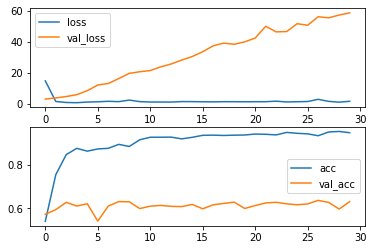

In [24]:
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(loss)
ax1.plot(val_loss)
ax1.legend(['loss','val_loss'])
ax2.plot(acc)
ax2.plot(val_acc)
ax2.legend(['acc','val_acc'])

In [25]:
tmp2 = []
j = 0
for i in test_df.processed.values:
  j = j +1
  if j % 200  == 0:
    print("")
  else:
    print(j,end=" ")
  tmp = []
  for x in i.split("|"):
    if x in id2w:
      tmp.append(w2id[x])
    else:
      tmp.append(w2id['UNK'])
  tmp2.append(tmp)
X_test2 = sequence.pad_sequences(tmp2, maxlen=max_length,truncating='post')
X_test2.shape

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278

(2674, 663)

In [26]:
y_pred = cls_model.predict_classes(X_test2)
y_real = test_df.real

In [27]:
from sklearn.metrics import classification_report

In [28]:
tmp = {'neg':0,'neu':1,'pos':2,'q':3}
tmp2 = []
for i in y_real.values:
  tmp2.append([tmp[i]])
y_real = tmp2

In [29]:
print(classification_report(y_real,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.64      0.62       683
           1       0.70      0.71      0.70      1456
           2       0.41      0.38      0.39       478
           3       0.43      0.11      0.17        57

    accuracy                           0.62      2674
   macro avg       0.53      0.46      0.47      2674
weighted avg       0.61      0.62      0.62      2674

